In [38]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal,Annotated
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
import operator

In [39]:
load_dotenv()

True

In [40]:
generator_llm  = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.7
)
evaluator_llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0
)
optimser_llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0
)

In [41]:
class TweetState(TypedDict):
  topic: str
  tweet: str
  evaluation: Literal['approved','rejected']
  feeback: str
  iteration: int
  max_iterations: int

  tweet_history: Annotated[list[str], operator.add]
  feedback_history: Annotated[list[str], operator.add]

In [42]:
class TweetEvaluation(BaseModel):
  evaluation: Literal['approved','rejected'] = Field(..., description="Whether the tweet meets the quality standards")
  feedback: str = Field(..., description="Constructive feedback on how to improve the tweet if rejected")

In [43]:
evaluator_structure_llm = evaluator_llm.with_structured_output(TweetEvaluation)


In [44]:
def generate(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [45]:
def evaluate(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = evaluator_structure_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [46]:
def optimize(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimser_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [47]:
def conditional_decision(state: TweetState):
    if state['evaluation'] == 'rejected' and state['iteration'] < state['max_iterations']:
        return 'need_imporvement'
    return 'approved'

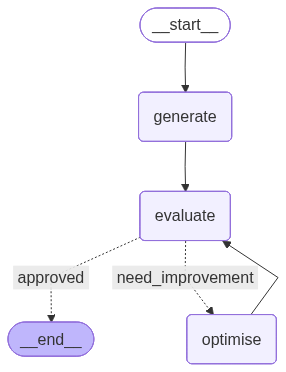

In [48]:
graph = StateGraph(TweetState)

graph.add_node('generate',generate)
graph.add_node('evaluate',evaluate)
graph.add_node('optimise',optimize)
graph.add_edge('optimise','evaluate')

graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')
graph.add_conditional_edges('evaluate',conditional_decision,{'need_improvement':'optimise','approved' : END})
workflow = graph.compile()
workflow

In [49]:
initial_state = {
    "topic": "indian railways",
    "iteration": 1,
    "max_iterations": 5
}
result = workflow.invoke(initial_state)
result

{'topic': 'indian railways',
 'tweet': '"Indian Railways: where delayed trains are on time, and on time trains are delayed. It\'s like they\'re playing a game of \'train roulette\' and we\'re all just spinning the wheel #IndianRailways #TrainTravel"',
 'evaluation': 'approved',
 'iteration': 1,
 'max_iterations': 5,
 'tweet_history': ['"Indian Railways: where delayed trains are on time, and on time trains are delayed. It\'s like they\'re playing a game of \'train roulette\' and we\'re all just spinning the wheel #IndianRailways #TrainTravel"'],
 'feedback_history': ["This tweet effectively uses wordplay and a relatable scenario to poke fun at the Indian Railways. The use of 'train roulette' is clever and engaging. However, it could benefit from a bit more originality and punchiness to make it truly stand out. Consider shortening the phrase 'where delayed trains are on time, and on time trains are delayed' to make it more concise and impactful."]}